# Xarray timeseries operations

There are several useful xarray timeseries operations, but for now we will discuss 2 of them: `groupby()` and `resample()`.

First, we need to load some data and calculate NDVI for it.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

import sys
sys.path.append('../../Scripts')

from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices

import datacube
dc = datacube.Datacube()

In [2]:
measurements = ['red', 'green', 'blue', 
                'nir', 'swir1', 'swir2']

landsat_ds = load_ard(dc=dc,
                      products=['ls8_usgs_sr_scene'], 
                      x=(39.221726, 39.296742),
                      y=(-6.770209, -6.736370),
                      time=("2017-01-01", "2017-12-31"),
                      measurements = measurements, 
                      output_crs="EPSG:4326", 
                      resolution=(-0.00027, 0.00027),
                      group_by='solar_day')
landsat_ds = calculate_indices(landsat_ds, index='NDVI', 
                               collection='c1')

Using pixel quality parameters for USGS Collection 1
Finding datasets
    ls8_usgs_sr_scene
Applying pixel quality/cloud mask
Loading 22 time steps


## Xarray groupby

The `groupby()` method applies other operations to data in groups defined by coordinate values.
For example, it can be used to calculate the mean, median, and other aggregate values for each time slice.
By default, `groupby()` groups by unique coordinate values of the specified dimensions.

Here, the mean NDVI for each time slice is calculated and plotted. The argument to `groupby()` is the dimension to group by coordinate values. The 3 dots in `median(...)` indicate that all dimensions other than the one grouped by (`time`) will be operated on.

In [3]:
median_ndvi_over_time = landsat_ds.NDVI.groupby('time').median(...)

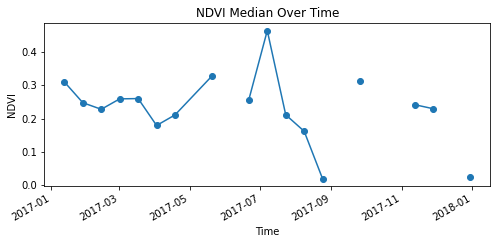

In [4]:
median_ndvi_over_time.plot(marker='o', figsize=(8,3))
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.title("NDVI Median Over Time")
plt.show()

### Binning

Another use of `groupby()` is binning - grouping by ranges of coordinate values.

For this we use the `groupby_bins()` method. The first argument is the dimension to group by and the second argument is the bin limits, so if there are 5 values here, as in the example below, there will be at most 4 groups - fewer if some of the bins have no data.

In [5]:
import pandas as pd

bins = (pd.Timestamp('01-01-2017').to_datetime64(), 
        pd.Timestamp('03-31-2017').to_datetime64(),
        pd.Timestamp('06-30-2017').to_datetime64(),
        pd.Timestamp('09-30-2017').to_datetime64(),
        pd.Timestamp('12-31-2017').to_datetime64())

ndvi_groupby_bins = landsat_ds.NDVI.groupby_bins('time', bins)

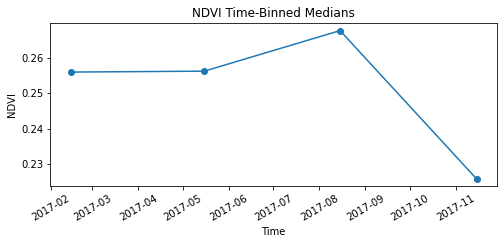

In [6]:
ndvi_groupby_bins.median(...).plot(marker='o', figsize=(8,3))
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.title("NDVI Time-Binned Medians")
plt.show()

As should be expected, the medians of the bins have less variance than the medians for individual time slices. Binning is one way to reduce variance in a plot without discarding any data when visualizing.

We can also define our own functions and call them on the grouped data with the function `map()`. In the following example, a function `double()` is defined which returns double its input group `x`, an xarray object. That function is then used in `map()` to return an xarray with doubled values.

In [7]:
def double(x):
    return x*2
ndvi_doubled = ndvi_groupby_bins.map(double)

print(f"Original NDVI median: {landsat_ds.NDVI.median().values:3f}")
print(f"Doubled NDVI median: {ndvi_doubled.median().values:3f}")

Original NDVI median: 0.253086
Doubled NDVI median: 0.506172


We could have achieved the same result with `2 * landsat_ds.NDVI` instead of using `groupby()` and `map()`, but `map()` is required for using custom functions and can be applied even without `groupby()`. In this case, every value is doubled, so the groups don't matter, so `groupby()` can even be omitted: `landsat_ds[['NDVI']].map(double)`. 

The purpose of that example is to show that these methods can be chained (`groupby()` -> `map()`). A more useful example in our context is applying a geomedian to each group, which can be done as follows:

In [8]:
from odc.algo import xr_geomedian
group_geomedians = \
    landsat_ds.groupby_bins('time', bins)\
    .map(lambda x: xr_geomedian(x))

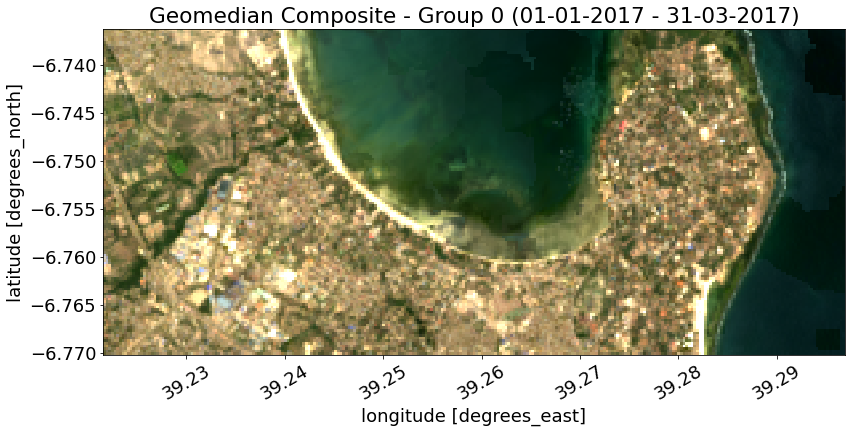

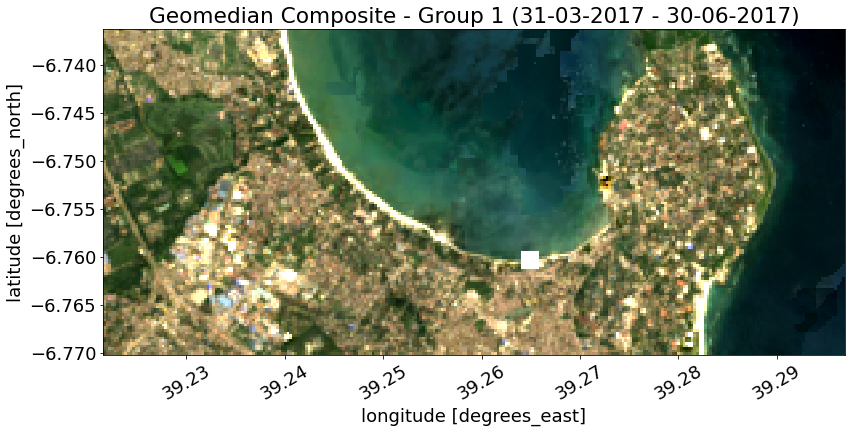

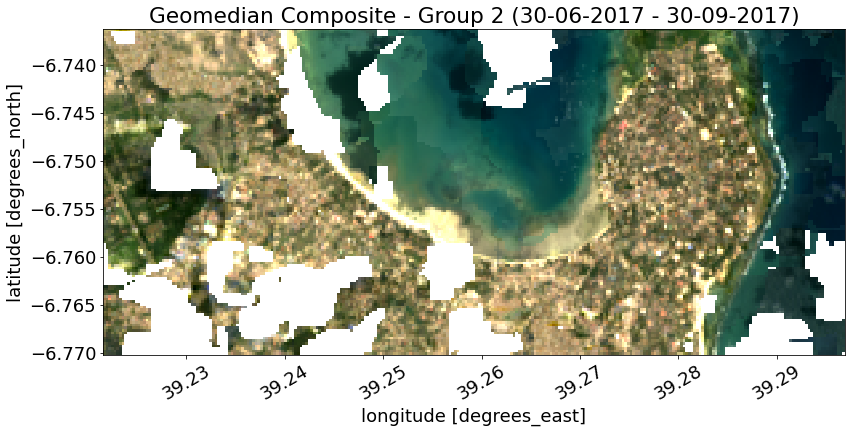

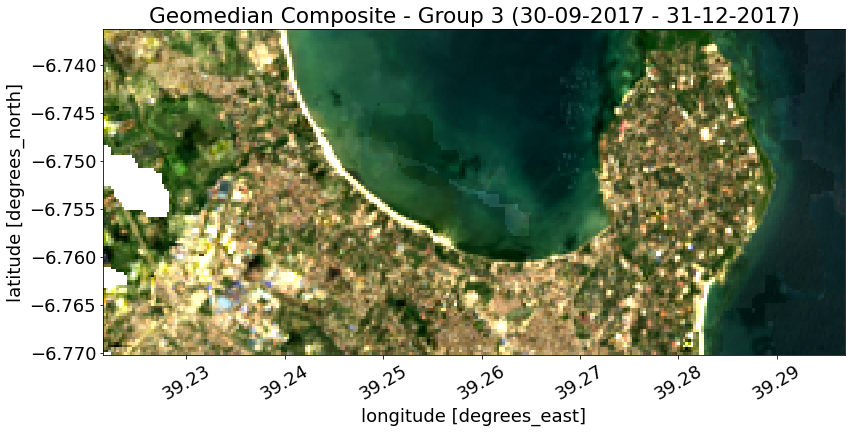

In [9]:
from deafrica_plotting import rgb

# Set the font size for this plot.
mpl.rcParams.update({'font.size': 18})

for time_ind, time_bin in enumerate(group_geomedians.time_bins):
    time_interval = np.atleast_1d(time_bin.values)[0]
    rgb(group_geomedians, index_dim='time_bins', index=time_ind)
    plt.xticks(rotation=30)
    plt.title(f"Geomedian Composite - Group {time_ind} "
              f"({time_interval.left.strftime('%d-%m-%Y')} - "
              f"{time_interval.right.strftime('%d-%m-%Y')})")
    plt.show()
    
# Restore the default font size.
mpl.rcParams.update(mpl.rcParamsDefault)

For more information on the `groupby()` method, see the documentation [here](http://xarray.pydata.org/en/stable/groupby.html).

## Xarray resample

The `resample()` method is similar to the `groupby()` method because both can be used to apply operations to groups of values. However, the resample method is a more convenient way to group data than `groupby_bins()`. Instead of defining specific ranges of values to group together, the `resample()` method only requires a dimension name and a resample frequency.

The following code resamples the NDVI data to 1 time slice per 3 months by obtaining the median across time for each group of 3 months of time slices. The Landsat 8 data that we have loaded has a revisit rate (time between time slices) of 16 days, so this reduces the amount of data since there will be more time (about 90 days) between time slices compared to the original data.

In [10]:
landsat_ds.NDVI.resample(time='6m').median()

<xarray.DataArray 'NDVI' (time: 3, latitude: 126, longitude: 279)>
array([[[ 0.23367797,  0.20137586,  0.1990232 , ...,  0.15044247,
          0.13599999,  0.11888114],
        [        nan,         nan,         nan, ...,  0.15044247,
          0.13599999,  0.11888114],
        [        nan,         nan,         nan, ...,  0.12307692,
          0.13178296,  0.12592591],
        ...,
        [ 0.42487043,  0.41935486,  0.3395862 , ...,  0.06329112,
          0.04255322,  0.0451613 ],
        [ 0.52302635,  0.44043043,  0.43894392, ...,  0.0295858 ,
          0.00483091,  0.01818179],
        [ 0.53213793,  0.4054818 ,  0.37682   , ...,  0.02487562,
          0.02040813,  0.01234566]],

       [[ 0.18277092,  0.15157482,  0.16591726, ..., -0.08881579,
         -0.09060334, -0.08875816],
        [ 0.23131444,  0.1493527 ,  0.15426107, ..., -0.08881579,
         -0.09060334, -0.08875816],
        [ 0.1599488 ,  0.15452072,  0.1582813 , ..., -0.09601953,
         -0.08009414, -0.09313802],
...
        [ 0.43823525,  0.4814815 ,  0.34567556, ..., -0.10770711,
         -0.09615386, -0.12149534],
        [ 0.5152186 ,  0.47951955,  0.47519428, ..., -0.09090912,
         -0.06666664, -0.07843138],
        [ 0.51243216,  0.43615934,  0.42742166, ..., -0.09090912,
         -0.09615386, -0.06122448]],

       [[ 0.21463287,  0.1876531 ,  0.21100742, ...,  0.00578034,
          0.        , -0.01734101],
        [ 0.25361767,  0.19689839,  0.21477087, ...,  0.00578034,
          0.        , -0.01734101],
        [ 0.2542432 ,  0.26185042,  0.2099932 , ..., -0.00544958,
          0.01453104,  0.01818179],
        ...,
        [ 0.503868  ,  0.5582329 ,  0.35353962, ...,  0.        ,
          0.00987653,  0.01201926],
        [ 0.42620146,  0.43898398,  0.34479904, ..., -0.00255754,
          0.00514138,  0.01020406],
        [ 0.27659574,  0.23662886,  0.25932205, ..., -0.00276243,
          0.        ,  0.02319168]]], dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-31 2017-07-31 2018-01-31
    spatial_ref  int32 4326
  * longitude    (longitude) float64 39.22 39.22 39.22 39.22 ... 39.3 39.3 39.3
  * latitude     (latitude) float64 -6.736 -6.737 -6.737 ... -6.77 -6.77 -6.77

As with `groupby()` or otherwise, `map()` can be run on the output of `resample()` (an `xarray.Dataset`).

In [11]:
resample_geomedians = \
    landsat_ds.resample(time='6m').map(lambda x: xr_geomedian(x))

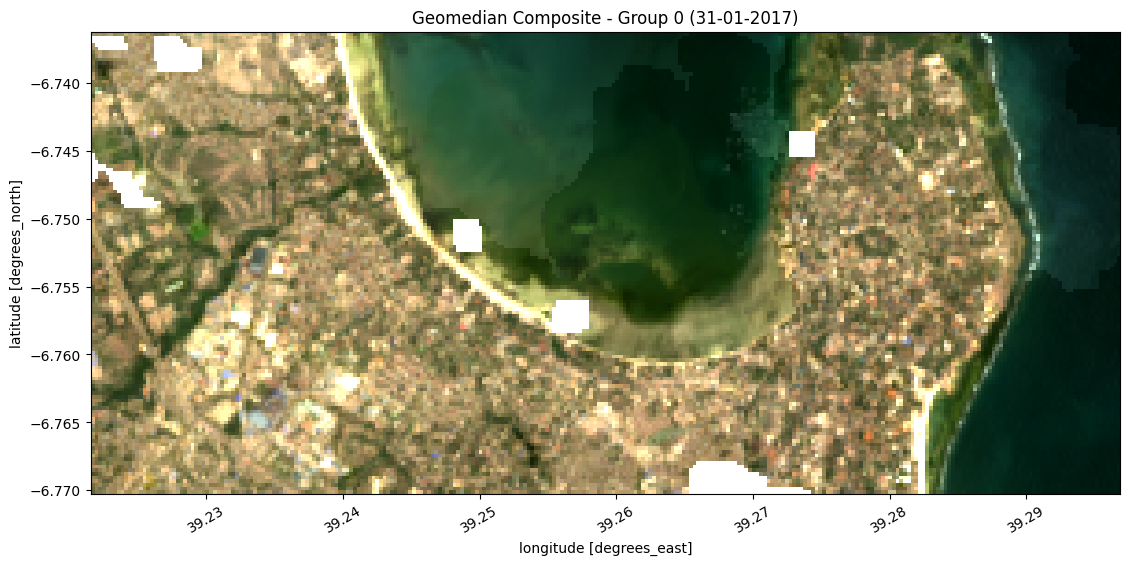

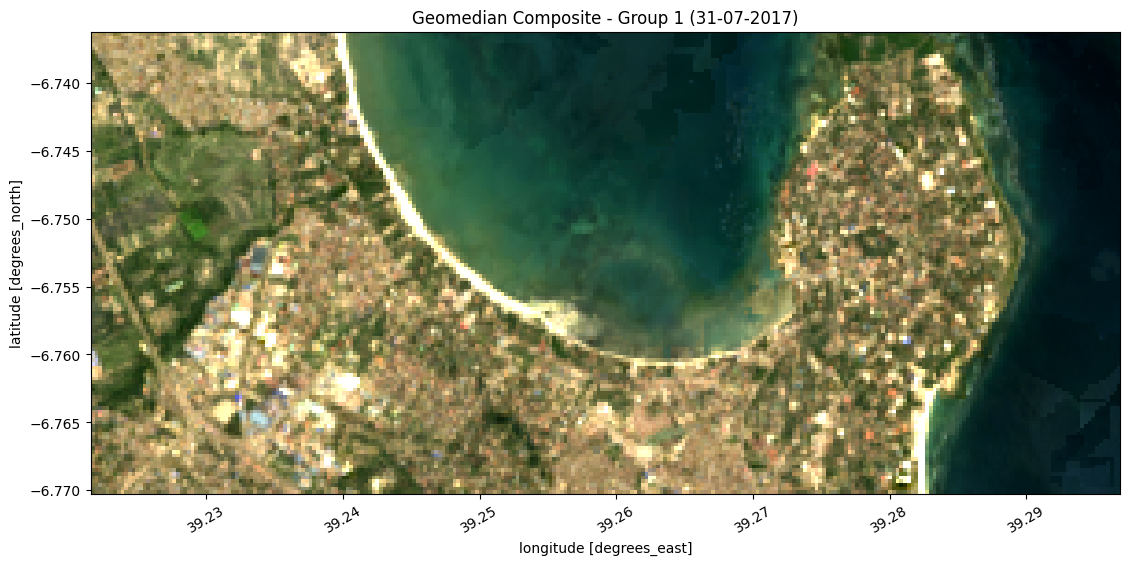

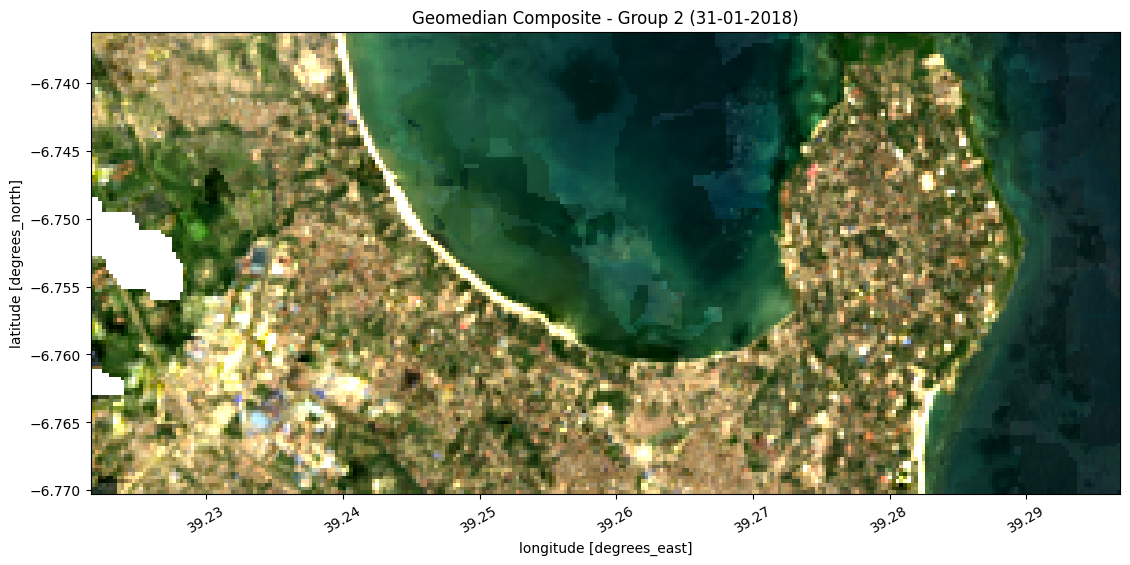

In [12]:
from deafrica_plotting import rgb

for time_ind, time in enumerate(resample_geomedians.time):
    rgb(resample_geomedians, index=time_ind)
    plt.xticks(rotation=30)
    plt.title(f"Geomedian Composite - Group {time_ind} "
              f"({pd.to_datetime(time.values).strftime('%d-%m-%Y')})")
    plt.show()

# Restore the default font size.
mpl.rcParams.update(mpl.rcParamsDefault)